# Weiss Schwarz Damage Simulation
Monte Carlo simulation of damage passing through, including trial count tuning and histogram output.

## Attack triggers and effect damage separation

Use `DamageEvent` to distinguish attack damage (which can roll soul triggers) from effect damage that bypasses trigger logic. 
Configure `DeckConfig.attacking_deck_size` and `DeckConfig.attacking_soul_trigger_cards` to represent the attacking player's deck when you want to include soul+1 triggers in attack resolution.

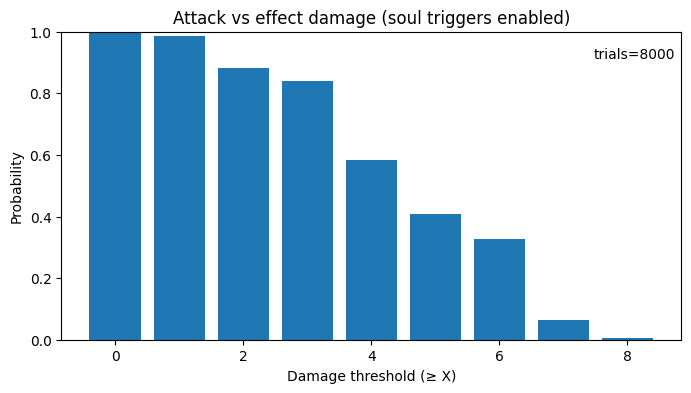

Trials used: 8000, mean damage=4.09, P(>=6)=0.327


In [4]:
from ws_sim.monte_carlo import DeckConfig, DamageEvent, simulate_trials, cumulative_probability_at_least, tune_trial_count
from ws_sim.plotting import plot_cumulative_histogram
import matplotlib.pyplot as plt

damage_sequence = [
    DamageEvent(base_damage=2, is_attack=True),
    DamageEvent(base_damage=1, is_attack=False),
    DamageEvent(base_damage=3, is_attack=True),
]

deck = DeckConfig(
    total_cards=50,
    climax_cards=8,
    attacking_deck_size=45,
    attacking_soul_trigger_cards=6,
)

chosen_trials, history = tune_trial_count(
    damage_sequence,
    deck,
    threshold=6,
    target_error=0.02,
    min_trials=500,
    seed=42,
)
damages = simulate_trials(damage_sequence, deck, trials=chosen_trials, seed=42)
thresholds = range(0, max(damages) + 1)
probabilities = cumulative_probability_at_least(damages, thresholds)

fig, ax = plot_cumulative_histogram(probabilities)
ax.set_title('Attack vs effect damage (soul triggers enabled)')
ax.text(0.99, 0.95, f'trials={chosen_trials}', transform=ax.transAxes, ha='right', va='top')
plt.show()
fig.savefig('../artifacts/damage_hist.png', bbox_inches='tight')

print(f'Trials used: {chosen_trials}, mean damage={sum(damages)/len(damages):.2f}, P(>=6)={probabilities.get(6, 0):.3f}')


## Simulating mid-sequence refreshes with a preloaded waiting room

Use `DeckConfig`'s `waiting_room_cards` and `waiting_room_climax_cards` to model game states where cards have already been routed to the waiting room before you start a damage sequence. The simulator will draw from the reduced deck size, shuffle the waiting room back when the deck empties, and automatically apply the one-damage refresh penalty whenever that shuffle happens mid-sequence. This makes it easy to study lines that intentionally compress the deck and to see how refresh timing impacts the damage curve.


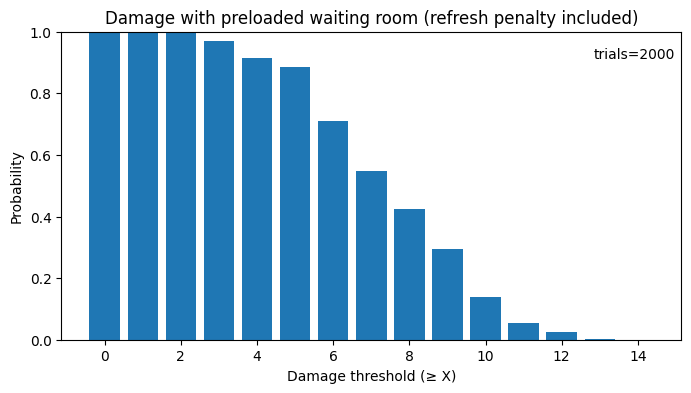

In [5]:
realistic_damage_sequence = [
    DamageEvent(base_damage=dmg)
    for dmg in (3, 2, 4, 3, 3, 4)
]

deck_with_waiting_room = DeckConfig(
    total_cards=50,
    climax_cards=8,
    waiting_room_cards=30,
    waiting_room_climax_cards=3,
)

mid_refresh_threshold = 7

chosen_trials_wr, history_wr = tune_trial_count(
    realistic_damage_sequence,
    deck_with_waiting_room,
    threshold=mid_refresh_threshold,
    target_error=0.02,
    min_trials=500,
    seed=7,
)

damages_with_refresh = simulate_trials(
    realistic_damage_sequence,
    deck_with_waiting_room,
    trials=chosen_trials_wr,
    seed=7,
)

thresholds_wr = range(0, max(damages_with_refresh) + 1)
probabilities_wr = cumulative_probability_at_least(damages_with_refresh, thresholds_wr)

fig_wr, ax_wr = plot_cumulative_histogram(probabilities_wr)
ax_wr.set_title("Damage with preloaded waiting room (refresh penalty included)")
ax_wr.text(0.99, 0.95, f'trials={chosen_trials_wr}', transform=ax_wr.transAxes, ha='right', va='top')
plt.show()

fig_wr.savefig('../artifacts/damage_hist_waiting_room.png', bbox_inches='tight')


## Main-phase effects with a seeded top stack

Fixing part of the top deck lets us model information gained from past triggers or mills before main-phase abilities fire.
The list in `seeded_top_stack` is ordered from the top card outward (``True`` = climax), and the helper rewrites the deck
before any cancellable damage resolves so the subsequent main-phase actions and battle attacks operate on the adjusted state.
The examples below compare the conditional 4-damage line (repeat 4 on CX cancel) against the CX-count-to-clock option, and
then continue into the same three-attack battle sequence while keeping the accumulated damage from the main phase.


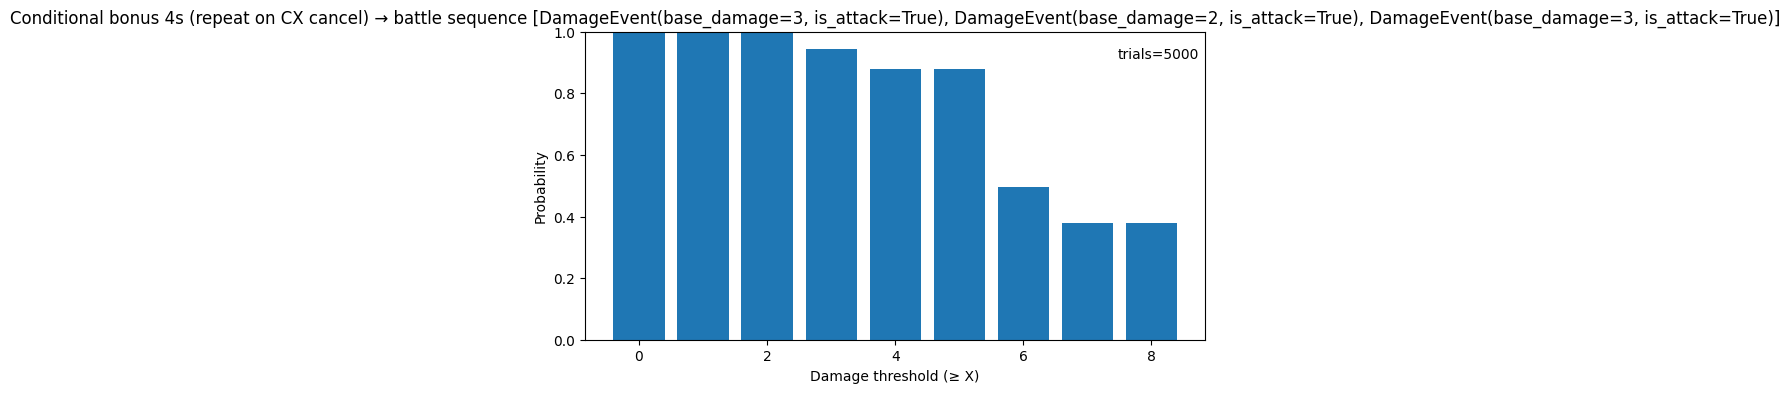

Conditional bonus 4s (repeat on CX cancel): mean=5.95, P(>=8)=0.378


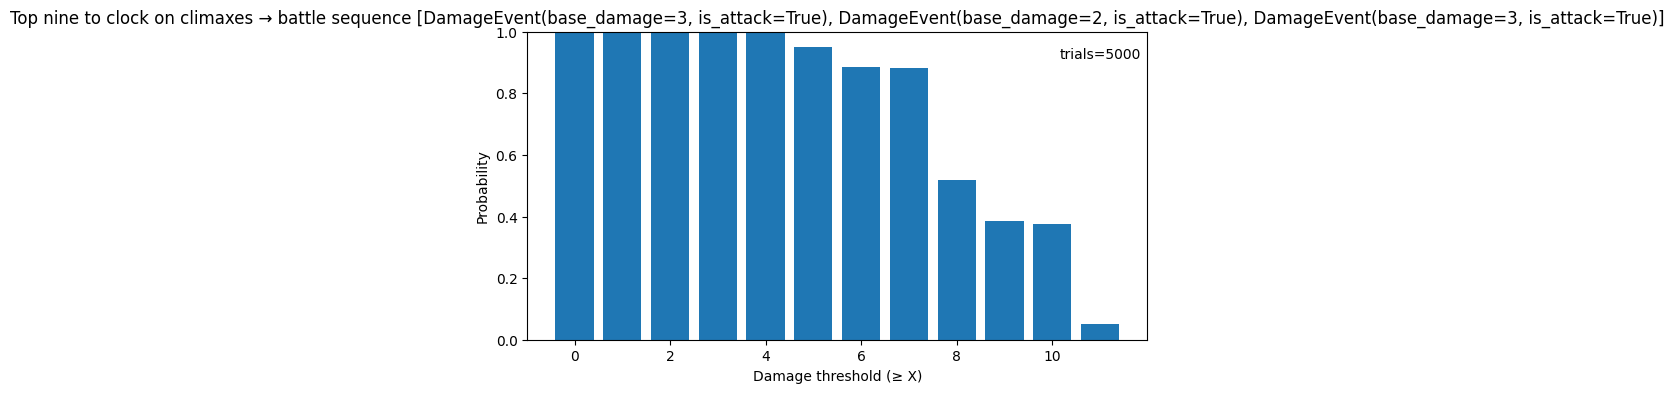

Top nine to clock on climaxes: mean=8.04, P(>=8)=0.520


In [6]:
from ws_sim.monte_carlo import (
    DamageEvent,
    DeckConfig,
    cumulative_probability_at_least,
    main_phase_four_damage_with_bonus,
    reveal_nine_clock_climaxes,
    simulate_trials,
)
from ws_sim.plotting import plot_cumulative_histogram
import matplotlib.pyplot as plt

seeded_top_stack = [True, False, False, False, True, False, False, False]


def seed_top_stack(deck_state, top_stack):
    total_climax_in_deck = sum(deck_state.deck)
    top_size = len(top_stack)
    if top_size > len(deck_state.deck):
        raise ValueError("Top stack longer than current deck")

    top_climax = sum(top_stack)
    remainder_size = len(deck_state.deck) - top_size
    remainder_climax = total_climax_in_deck - top_climax
    if remainder_climax < 0 or remainder_climax > remainder_size:
        raise ValueError("Top stack uses more climax cards than available in deck")

    remainder = [True] * remainder_climax + [False] * (remainder_size - remainder_climax)
    deck_state.rng.shuffle(remainder)
    deck_state.deck = remainder + list(reversed(top_stack))
    return 0


def apply_seeded_top_stack(deck_state):
    return seed_top_stack(deck_state, seeded_top_stack)


battle_damage_sequence = [
    DamageEvent(base_damage=dmg)
    for dmg in (3, 2, 3)
]
seeded_deck = DeckConfig(
    total_cards=50,
    climax_cards=8,
    waiting_room_cards=12,
    waiting_room_climax_cards=3,
)

main_phase_lines = {
    "Conditional bonus 4s (repeat on CX cancel)": [
        apply_seeded_top_stack,
        main_phase_four_damage_with_bonus,
    ],
    "Top nine to clock on climaxes": [
        apply_seeded_top_stack,
        reveal_nine_clock_climaxes,
    ],
}

trial_count = 5000
for label, steps in main_phase_lines.items():
    damages = simulate_trials(
        battle_damage_sequence,
        seeded_deck,
        trials=trial_count,
        seed=2024,
        main_phase_steps=steps,
    )
    thresholds = range(0, max(damages) + 1)
    probabilities = cumulative_probability_at_least(damages, thresholds)
    mean_damage = sum(damages) / len(damages)
    eight_plus = probabilities.get(8, 0)

    fig, ax = plot_cumulative_histogram(probabilities)
    ax.set_title(f"{label} → battle sequence {battle_damage_sequence}")
    ax.text(0.99, 0.95, f"trials={trial_count}", transform=ax.transAxes, ha="right", va="top")
    plt.show()
    fig.savefig(f"../artifacts/{label.split()[0].lower()}_seeded_stack.png", bbox_inches="tight")

    print(f"{label}: mean={mean_damage:.2f}, P(>=8)={eight_plus:.3f}")
